# Crank-Nicholson


<p style="font-size:24px">This Notebook contains an explanation on how Crank-Nicholson method was used in order to solve the mathermatical model</p>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Model parameters
r_n1 = 1.0e-6    # Normal cell growth rate
r_n2 = 1.0       # Acid-induced death rate
r_t1 = 1.0e-6    # Tumor growth rate
r_h1 = 2.2e-17   # H+ production rate
r_h2 = 1.1e-4    # H+ decay rate
K_n = 5.0e7      # Normal cell capacity
K_t = 5.0e7      # Tumor cell capacity
D_t = 2.0e-10    # Tumor diffusivity
D_h = 5.0e-6     # H+ diffusivity

The previous segment of the code is the simple of first step of defining the parameters of the equation and importing the required libraries that we will be using in our solution.

In [9]:
# Spatial grid
R = 0.5          # Domain radius [cm]
Nr = 101         # Number of spatial points
r = np.linspace(0, R, Nr)
dr = r[1] - r[0]

# Time parameters
dt = 1e4         # Time step
Nt = 500         # Number of time steps
t_final = Nt * dt

Here, we define our temporal and spatial grids through discretization. The spatial domain ranges from 0 to 0.5 cm and is divided into 101 nodes (or points). For the time domain, we use a time step of 10,000 seconds and a total of 500 time steps.

In [10]:
# Initialize fields and storage for time points
def initial_conditions(r):
    """Create initial conditions using tanh profile"""
    N_n = np.zeros_like(r)
    N_t = np.zeros_like(r)
    C_h = np.zeros_like(r)

    rs = 50  # Scaling factor
    r0_n = 0.1  # Transition point for normal cells
    r0_t = 0.1  # Transition point for tumor cells
    r0_h = 0.05  # Transition point for acid

    for i in range(len(r)):
        # Normal cells
        tanhr = np.tanh(rs * (r[i] - r0_n))
        N_n[i] = 5.0e7 * (1 - tanhr) / 2 + 1.0e8 * (1 + tanhr) / 2

        # Tumor cells
        tanhr = np.tanh(rs * (r[i] - r0_t))
        N_t[i] = 1.0e5 * (1 - tanhr) / 2 + 1.0e3 * (1 + tanhr) / 2

        # Acid concentration
        tanhr = np.tanh(rs * (r[i] - r0_h))
        C_h[i] = 1.0e-9 * (1 - tanhr) / 2 + 0.0 * (1 + tanhr) / 2

    return N_n, N_t, C_h

N_n, N_t, C_h = initial_conditions(r)


Here, we set up the initial conditions of the equations using a tanh profile for the three unknowns: normal cells (Nₙ), tumor cells (Nₜ), and excess lactic acid (Cₕ). The initial conditions are based on ones provided by the reference.

In [11]:
# Create storage for multiple time points
snapshot_times = [0, 100, 200, 300, 400, 499]  # Time indices to store
time_points = len(snapshot_times)
N_n_history = np.zeros((Nr, time_points))
N_t_history = np.zeros((Nr, time_points))
C_h_history = np.zeros((Nr, time_points))
pH_history = np.zeros((Nr, time_points))

# Store initial condition
N_n_history[:, 0] = N_n
N_t_history[:, 0] = N_t
C_h_history[:, 0] = C_h
pH_history[:, 0] = -np.log10(4.0e-8 + C_h)

In this section, we allocate memory to store the computed values of the three
unknowns—normal cells (Nₙ), tumor cells (Nₜ), and excess lactic acid (Cₕ)—at selected time steps throughout the simulation. These selected time steps are specified by the snapshot_times list, which allows us to capture the evolution of the system at key intervals without storing data at every time step. The number of snapshots is stored in time_points, and each variable is stored as a 2D array of shape (Nr, time_points), where Nr is the number of spatial points.

Additionally, we store the initial condition (t = 0) for all three variables in the first column of their corresponding history arrays. The pH field is also computed from the acid concentration using the relation pH = -log10([H⁺]) and stored similarly. This setup enables efficient post-processing, when plotting the time evolution of the system once the Crank-Nicolson time-stepping loop is complete.

In [12]:
# Create differentiation matrices for Crank-Nicolson
def create_diffusion_matrix(r, dr, D):
    """Create matrix for (1/r²)∂/∂r(r²D∂u/∂r)"""
    N = len(r)
    main_diag = np.zeros(N)
    lower_diag = np.zeros(N - 1)
    upper_diag = np.zeros(N - 1)

    for i in range(1, N - 1):
        r_plus = r[i] + dr / 2
        r_minus = r[i] - dr / 2

        alpha = D[i] * r_plus ** 2 / (r[i] ** 2 * dr ** 2)
        beta = D[i] * r_minus ** 2 / (r[i] ** 2 * dr ** 2)

        lower_diag[i - 1] = beta
        main_diag[i] = -(alpha + beta)
        upper_diag[i] = alpha

    # Boundary conditions
    main_diag[0] = -3 * D[0] / dr ** 2
    upper_diag[0] = 3 * D[0] / dr ** 2

    main_diag[-1] = 1
    lower_diag[-1] = -1

    return diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csc')

In this section, we construct a **sparse matrix** that discretizes the radial diffusion operator used in the Crank-Nicolson scheme for solving our PDEs in spherical symmetry, and apply the boundary conditions.

--------------------------------------------------------

We are discretizing the following diffusion operator:

$$
\frac{1}{r^2} \frac{d}{dr} \left( r^2 D(n) \frac{du}{dr} \right)
$$

This appears in the equations for both tumor cells $ N_t $ and acid concentration $C_h$, and accounts for diffusion in a radially symmetric domain.

---

For each interior spatial point $ i $, we calculate:

$$
\alpha_i = \frac{D_i \cdot \left( r_i + \frac{\Delta r}{2} \right)^2}{r_i^2 \cdot \Delta r^2}, \quad
\beta_i = \frac{D_i \cdot \left( r_i - \frac{\Delta r}{2} \right)^2}{r_i^2 \cdot \Delta r^2}
$$

- $\alpha_i$: captures diffusion flux to the right of the point  
- $\beta_i$: captures diffusion flux to the left of the point


These coefficients are used to populate a tridiagonal matrix representing the finite difference approximation of the diffusion term.<br> **Where the matrix entries at boundaries are calculated using the boundary conditions (?)**.

---



The matrix $ A $ is a tridiagonal and at this point looks like this:

$$
A =
\begin{bmatrix}
? & ? & 0 & \cdots & 0 \\
\beta_1 & -(\alpha_1 + \beta_1) & \alpha_1 & \cdots & 0 \\
0 & \beta_2 & -(\alpha_2 + \beta_2) & \alpha_2 & \cdots \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & \beta_{N-2} & -(\alpha_{N-2} + \beta_{N-2}) & \alpha_{N-2} \\
0 & \cdots & 0 & ? & ?
\end{bmatrix}
$$

---


## Applying BC's At $ r = 0 $: L’Hôpital's Rule
Now we move on to applying boundary conditions in our matrix to calculate the remaining matrix entries.<br><br>

$$
\left. \frac{1}{r^2} \frac{d}{dr} \left( r^2 D(N_n) \frac{du}{dr} \right) \right|_{r=0} = 3D(N_n) \frac{d^2u}{dr^2}
$$

This is approximated as:

$$
\frac{d^2u}{dr^2} \approx \frac{u_1 - u_0}{\Delta r^2}
$$

This leads to the matrix entries:

- $$ A_{0,0} = -3D_0/\Delta r^2 $$
- $$ A_{0,1} = 3D_0/\Delta r^2 $$

--------------------------------------------------------------------------------

##  At  $ r = R $  Neumann Boundary Condition

We assume zero-flux at the boundary:

$$
\left. \frac{du}{dr} \right|_{r=R} = 0 \Rightarrow u_{N-1} = u_{N-2}
$$

This is enforced by:

- $$ A_{N-1,N-2} = -1 $$
- $$ A_{N-1,N-1} = 1 $$

---
Finally matrix $A$ is obtained as:
$$
A =
\begin{bmatrix}
-3D_0/\Delta r^2 & 3D_0/\Delta r^2 & 0 & \cdots & 0 \\
\beta_1 & -(\alpha_1 + \beta_1) & \alpha_1 & \cdots & 0 \\
0 & \beta_2 & -(\alpha_2 + \beta_2) & \alpha_2 & \cdots \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & \beta_{N-2} & -(\alpha_{N-2} + \beta_{N-2}) & \alpha_{N-2} \\
0 & \cdots & 0 & -1 & 1
\end{bmatrix}
$$



In [13]:
# Time-stepping with Crank-Nicolson
for n in range(1, Nt):
    D = D_t * (1 - N_n / K_n)
    D[D < 0] = 0

    A_tumor = create_diffusion_matrix(r, dr, D)
    A_acid = create_diffusion_matrix(r, dr, D_h * np.ones_like(r))

    I = diags([np.ones(Nr)], [0], format='csc')

    reaction_old = r_n1 * N_n * (1 - N_n / K_n) - r_n2 * C_h * N_n
    N_n_pred = N_n + dt * reaction_old
    reaction_new = r_n1 * N_n_pred * (1 - N_n_pred / K_n) - r_n2 * C_h * N_n_pred
    N_n = N_n + 0.5 * dt * (reaction_old + reaction_new)

    reaction_old = r_t1 * N_t * (1 - N_t / K_t)
    N_t_pred = N_t + dt * (reaction_old + A_tumor.dot(N_t))
    reaction_new = r_t1 * N_t_pred * (1 - N_t_pred / K_t)

    lhs = I - 0.5 * dt * A_tumor
    rhs = N_t + 0.5 * dt * (reaction_old + reaction_new + A_tumor.dot(N_t))
    N_t = spsolve(lhs, rhs)

    reaction_old = r_h1 * N_t - r_h2 * C_h
    C_h_pred = C_h + dt * (reaction_old + A_acid.dot(C_h))
    reaction_new = r_h1 * N_t - r_h2 * C_h_pred

    lhs = I - 0.5 * dt * A_acid
    rhs = C_h + 0.5 * dt * (reaction_old + reaction_new + A_acid.dot(C_h))
    C_h = spsolve(lhs, rhs)

    N_t[0] = N_t[1]
    N_t[-1] = N_t[-2]
    C_h[0] = C_h[1]
    C_h[-1] = C_h[-2]

    if n in snapshot_times[1:]:
        idx = snapshot_times.index(n)
        N_n_history[:, idx] = N_n
        N_t_history[:, idx] = N_t
        C_h_history[:, idx] = C_h
        pH_history[:, idx] = -np.log10(4.0e-8 + C_h)


### Time-Stepping with Crank-Nicolson

In this block, we evolve the system forward in time using a combination of numerical techniques:

- **Normal cells** are updated by using a predictor-corrector (explicit trapezoidal) method.
- **Tumor cells** and **acid concentration** are governed by **PDEs** with radial diffusion and are solved using the **Crank-Nicolson scheme**.

---
### Normal Cell Update

The equation for normal cells is purely a reaction equation (no diffusion):

$$
\frac{\partial N_n}{\partial t} = r_{n1} N_n \left(1 - \frac{N_n}{K_n}\right) - r_{n2} C_h N_n
$$

We use an explicit **predictor-corrector** approach:

1. Predict with forward Euler  
2. Correct with trapezoidal averaging


---

### Tumor Cell Update

Tumor cells follow a **reaction-diffusion equation**:

$$
\frac{\partial N_t}{\partial t} = r_{t1} N_t \left(1 - \frac{N_t}{K_t} \right) + \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 D(N_n) \frac{\partial N_t}{\partial r} \right)
$$

Steps:
- Compute the nonlinear reaction term
- Use Crank-Nicolson to solve the diffusion-reaction PDE:

$$
\left(I - \frac{\Delta t}{2} A\right) N_t^{n+1} = N_t^n + \frac{\Delta t}{2} \left(f^n + f^{n+1} + A N_t^n \right)
$$

Here, $ A $ is the diffusion matrix generated from the spatial operator that we previously calculated, and `spsolve` solves the resulting sparse linear system.

---

### Acid Concentration Update

The acid concentration also evolves via a reaction-diffusion equation:

$$
\frac{\partial C_h}{\partial t} = r_{h1} N_t - r_{h2} C_h + D_h \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_h}{\partial r} \right)
$$

Similar steps as for tumor cells:
- Evaluate reaction source terms
- Use Crank-Nicolson with fixed diffusivity \( D_h \)

---

### Boundary Conditions

To maintain physical realism:
- At $ r = 0 $: symmetry → copy value from index 1
- At $ r = R $: no-flux (Neumann) → copy value from second-to-last point

This ensures that the radial derivative is zero at both ends.

---


After completing the time-stepping loop (**the one shown below**), this final section of the code focuses on storing and visualizing the results. The model saves the computed values of normal cell density, tumor cell density, acid concentration, and pH at specific time steps defined in snapshot_times. This allows us to track how the system evolves without storing data at every step. <br><br>Once the simulation finishes, the code generates a 2×2 grid of plots that display the spatial distribution of each variable across the tissue radius over time. These plots provide a visual summary of how the tumor grows, how acidity spreads, and how normal cells are affected throughout the simulation.<br> <br>
Finally, we can note that the total time complexity of the code is $O(Nt * Nr)$ as it is the most dominant term. Where $Nr$ is the number of nodes in the spatial grids and $Nt$ is the number of time steps.

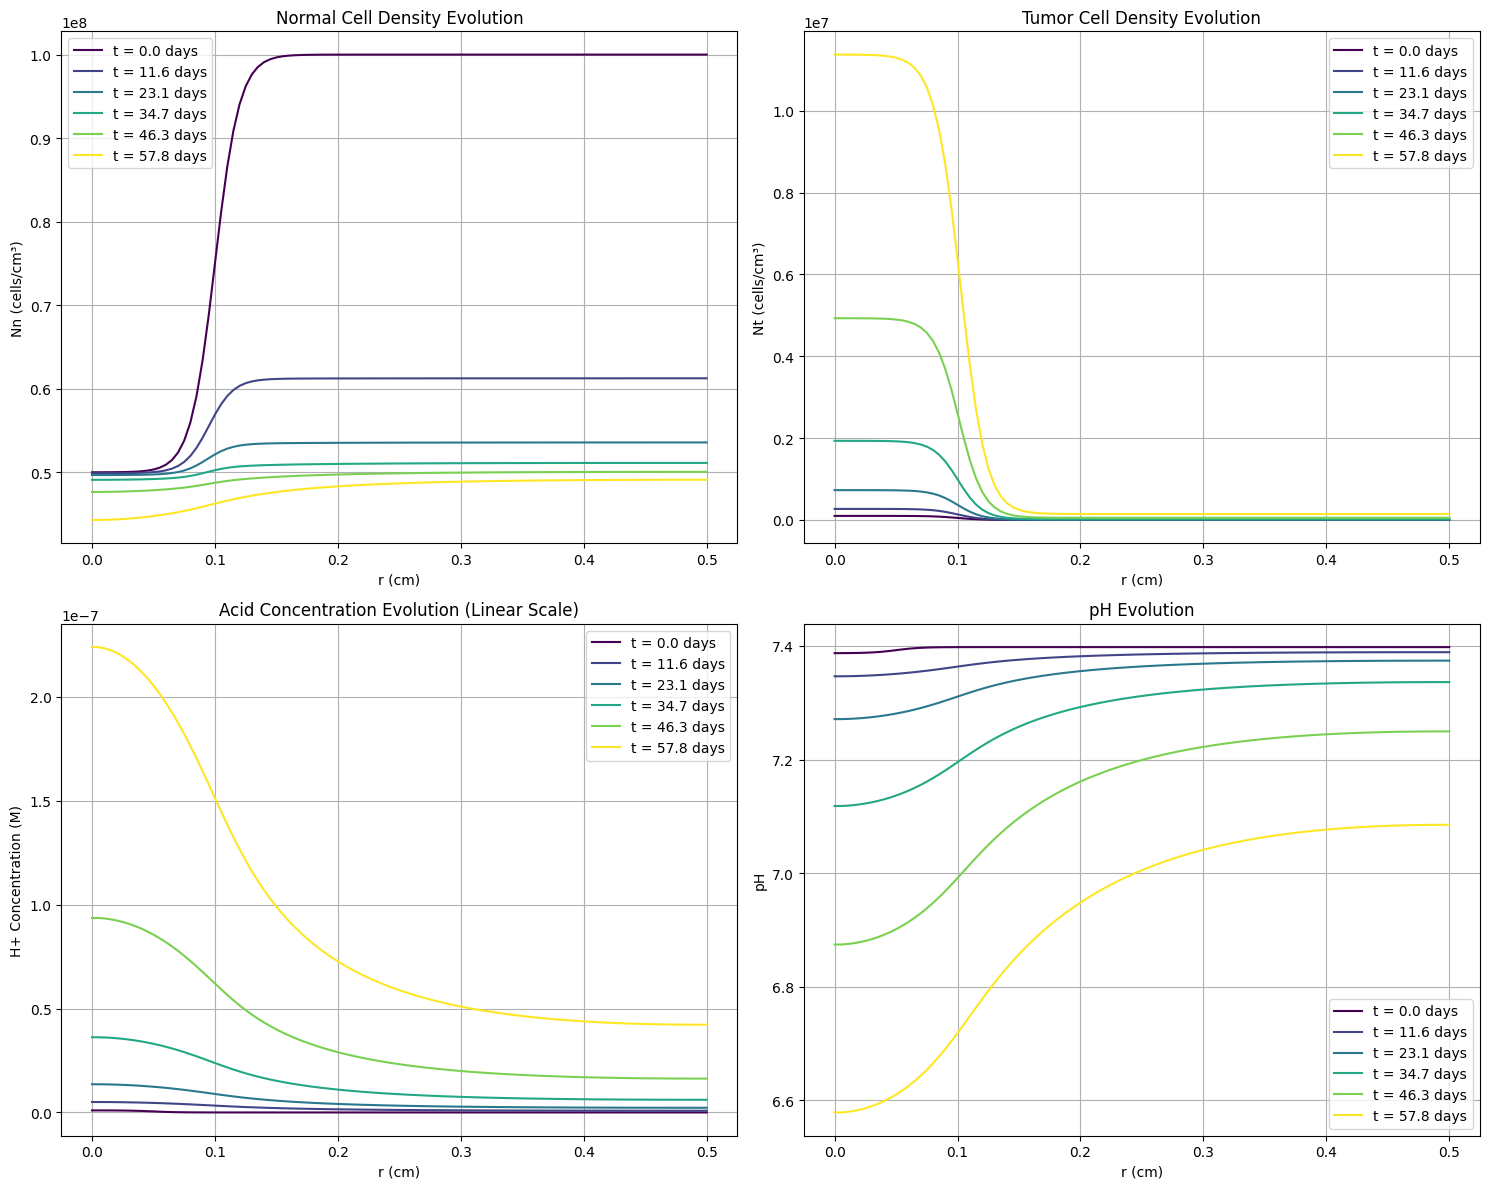

In [14]:
plt.figure(figsize=(15, 12))
colors = plt.cm.viridis(np.linspace(0, 1, time_points))

plt.subplot(2, 2, 1)
for i in range(time_points):
    plt.plot(r, N_n_history[:, i], color=colors[i],
             label=f't = {snapshot_times[i] * dt / (24 * 3600):.1f} days')
plt.xlabel('r (cm)')
plt.ylabel('Nn (cells/cm³)')
plt.title('Normal Cell Density Evolution')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for i in range(time_points):
    plt.plot(r, N_t_history[:, i], color=colors[i],
             label=f't = {snapshot_times[i] * dt / (24 * 3600):.1f} days')
plt.xlabel('r (cm)')
plt.ylabel('Nt (cells/cm³)')
plt.title('Tumor Cell Density Evolution')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for i in range(time_points):
    plt.plot(r, C_h_history[:, i], color=colors[i],
             label=f't = {snapshot_times[i] * dt / (24 * 3600):.1f} days')
plt.xlabel('r (cm)')
plt.ylabel('H+ Concentration (M)')
plt.title('Acid Concentration Evolution (Linear Scale)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i in range(time_points):
    plt.plot(r, pH_history[:, i], color=colors[i],
             label=f't = {snapshot_times[i] * dt / (24 * 3600):.1f} days')
plt.xlabel('r (cm)')
plt.ylabel('pH')
plt.title('pH Evolution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
